In [1]:
import sys
import numpy as np
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection

from functools import reduce
import operator

import torch
from torch import nn
from torch.nn.utils import clip_grad_norm
from torch.autograd import Variable
from torch import optim

#from models import EulerRNN
from RateUnitNetwork import RateUnitNetwork

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Helper Functions

In [2]:
def var_penalty(xt0,xt1):
    return torch.sqrt(torch.pow(xt1-xt0, 2).mean())

def batch_var_penalty(hiddens):
    return hiddens.std(dim=1).mean()

def l2_penalty(w):
    return torch.sqrt(torch.pow(w,2).mean())

# def get_batch(input_size, xmin, xmax, batch_size, n_steps):
#     x0 = np.random.uniform(xmin, xmax, size=(batch_size, input_size))
#     inputs = Variable(torch.zeros(batch_size, n_steps, input_size))
#     targets = inputs.clone()
#     inputs[:,0,:] = torch.from_numpy(x0)
#     targets[...] = torch.from_numpy(x0).unsqueeze(1) # to get expansion over time
#     return inputs, targets


def get_batch(input_size, xmin, xmax, batch_size, n_steps, init_steps, pulse_width = 1):
    x0 = np.random.uniform(xmin, xmax, size=(batch_size, input_size))
    inputs = Variable(torch.zeros(batch_size, n_steps + init_steps, input_size))
    targets = inputs.clone()
    inputs[:,init_steps:init_steps+pulse_width,:] = torch.from_numpy(x0).unsqueeze(1)
    #CHECKME JK!
    targets[:,init_steps:,:] = torch.from_numpy(x0).unsqueeze(1) # to get expansion over time
    return inputs, targets

# (hyper)parameters

In [19]:
# Inputs
input_size = 2
xmin = -1
xmax = 1

# Integration
dt = 0.1
tau = 1 # Implicit in RateUnitNetwork
n_steps = int(100*tau/dt)

# Training
n_epochs = 8000
init_steps = int(20*tau/dt) # initialize randomly and run for 20 tau before injecting input
pulse_width = int(5*tau/dt)

tbptt_steps = None # 5
batch_size = 64
#NOTUSED penalize_fixed = True
eta = 5e-5
#lam = 0.001

# Model Architecture
hidden_size = 400
prob_conn = 0.25
g = 1.5

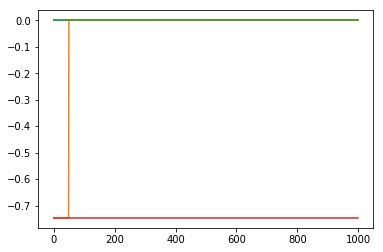

In [4]:
foo, bar = get_batch(input_size, xmin, xmax, batch_size, n_steps, pulse_width)
_=plt.plot(np.arange(n_steps), *foo[0].numpy().T) #, *batch_targets[0][1].numpy().T)
_=plt.plot(np.arange(n_steps), *bar[0].numpy().T) #, *batch_targets[0][1].numpy().T)

In [5]:
model = RateUnitNetwork(input_size, hidden_size, input_size, dt, include_bias = False)
#model.init_chaos(prob_conn, g)
#model.h2h.weight.register_hook(lambda x: print(torch.norm( (x / model.h2h.weight)[h2h_mask])))
#model.h2h.weight.register_hook(lambda x: print(torch.norm((x / model.h2h.weight)[np.where(h2h_mask)])))

i2h = model.i2h.weight.detach().numpy()
h2h = model.h2h.weight.detach().numpy()
h2o = model.h2o.weight.detach().numpy()
print('INITIAL (|i2h|, |h2h|, |h2o|) = (%f, %f, %f)' %\
      (np.linalg.norm(i2h), np.linalg.norm(h2h), np.linalg.norm(h2o)) 
     )

# bi2h = model.i2h.bias.detach().numpy()
# #bh2h = model.h2h.bias.detach().numpy()
# bh2o = model.h2o.bias.detach().numpy()
# print('INITIAL (|bias_i2h|, |bias_h2h|, |bias_h2o|) = (%f, %f, %f)' %\
#       (np.linalg.norm(bi2h), 0, np.linalg.norm(bh2o)) 
#      ) #np.linalg.norm(bh2h)

INITIAL (|i2h|, |h2h|, |h2o|) = (11.803874, 11.533716, 0.813546)


# Intrinsic dynamics

In [6]:
test_steps = 1000
test_batch_size = 8

with torch.no_grad():
    test_hidden = 2*torch.rand((test_batch_size, hidden_size))-1
    out, hid = model(torch.zeros(test_batch_size, test_steps, input_size), test_hidden)
    intrinsic_out = out.detach().numpy()
    intrinsic_hid = hid.detach().numpy()

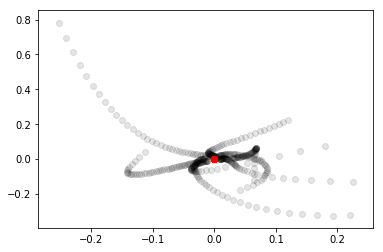

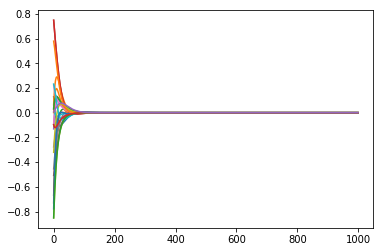

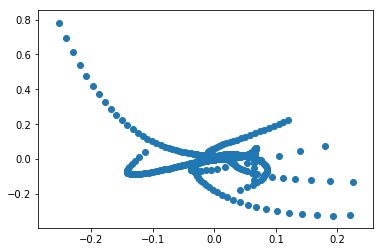

In [7]:
plt.figure()
plt.scatter(*intrinsic_out[:,:int(test_steps/20),:].T, color = 'k', alpha = 0.1)
plt.scatter(*intrinsic_out[:,-int(test_steps/20):,:].T, color = 'r', alpha = 0.1)

plt.figure()
i=np.random.randint(test_batch_size)
k=np.random.randint(0, hidden_size, 25)
_ = plt.plot(intrinsic_hid[i,:,k].T)

plt.figure()
plt.scatter(*intrinsic_out.T)

#     plt.xlim([-1,1])
#     plt.ylim([-1,1])
#plt.scatter(*targets[:,0,:].numpy().T, color='r')
# TODO?: convex hull of samples vs time, as a measure of convergence to single FP

# Train

In [8]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=eta)
losses = np.zeros(n_epochs)
testerr = np.zeros(n_epochs)

len_Wi2h = np.zeros(n_epochs)
len_Wh2h = np.zeros(n_epochs)
len_Wh2o = np.zeros(n_epochs)

# Wi2h = np.zeros((n_epochs, hidden_size, input_size))
# Wh2h = np.zeros((n_epochs, hidden_size, hidden_size))
# Wh2o = np.zeros((n_epochs, input_size, hidden_size))

len_h2h_grad = np.zeros(n_epochs)

for i in range(n_epochs): 
    if i%(n_epochs/100) == 0:
        sys.stdout.write('..%i' % int(float(i)/(n_epochs/100)))
    inputs, targets = get_batch(input_size, xmin, xmax, batch_size, n_steps)
    

    # Initialize hidden
    hidden = 2*torch.rand((batch_size, hidden_size))-1
    
    # Integrate for init_steps
    #UPDATE: train during initial delay epoch as well... 
    #outputs, hiddens = model(torch.zeros(batch_size, init_steps, input_size), hidden)

    if tbptt_steps is not None: # Use TBPTT
        batch_inputs = torch.split(inputs, bptt_steps, dim = 1)
        batch_targets = torch.split(targets, bptt_steps, dim = 1)
        for inp, tgt in zip(batch_inputs, batch_targets):
            outputs, hiddens = model(inp, hidden)
            hidden = hiddens[:,-1,:].detach()
            loss = criterion(outputs, tgt)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            losses[i]+=loss.data.item()
    else: # Use BPTT on full sequence
        #UPDATE: train during delay epoch as well ... hidden = hiddens[:,-1,:].detach()
        outputs, hiddens = model(inputs, hidden)
        loss = criterion(outputs, targets)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        losses[i]+=loss.data.item()

        
    #UPDATED1: pass the input pulse but don't train (per Buonomano's implementation)
    #outputs, hiddens = model(inputs[:,:pulse_width,:], hiddens[:,-1,:].detach())
    
    #TODO: go back to training 1 pattern at a time and see wtf happens...
    # should be same result, or convergence to that single pattern ... 
    #for j in range(batch_size):
    #    sys.stdout.write('..%i' % j)

    # UPDATED0: BPTT with a window and stepping forward 
    #for t in range(pulse_width, n_steps-bptt_steps):
    #    #batch_in = inputs[[j],t:t+bptt_steps,...]
    #    #batch_tgt = targets[[j],t:t+bptt_steps,...]
    #    #hidden = hiddens[:,[0],:].detach()
    #    batch_in = inputs[:,t:t+bptt_steps,...]
    #    batch_tgt = targets[:,t:t+bptt_steps,...]
    #    hidden = hiddens[:,0,:].detach()
    #    outputs, hiddens = model(batch_in, hidden)
    #    loss = criterion(outputs, batch_tgt)
    #    model.zero_grad()
    #    loss.backward()
    #    #clip_grad_norm(model.parameters(), 0.5) # torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_
    #    len_h2h_grad[i] += np.linalg.norm(model.h2h.weight.grad.detach().numpy())
    #    losses[i]+=loss.data.item()
    #    #print(loss.data[0])
    #    optimizer.step()
    #    #foo.append(model.h2h.weight.detach().numpy())   
    
    #print('final tbatch err = ', torch.pow(outputs-targets,2).sum(0).mean())
    
    i2h = model.i2h.weight.detach().numpy()
    h2h = model.h2h.weight.detach().numpy()
    h2o = model.h2o.weight.detach().numpy()
    #Wi2h[i] = i2h
    #Wh2h[i] = h2h
    #Wh2o[i] = h2o
    len_Wi2h[i] = np.linalg.norm(i2h)
    len_Wh2h[i] = np.linalg.norm(h2h)
    len_Wh2o[i] = np.linalg.norm(h2o)
    if any([np.isnan(x).any() for x in [i2h, h2h, h2o]]):
        print('NaNs, breaking at epoch=%i...' % i)
        break
#     print('(|i2h|, |h2h|, |h2o|) = (%f, %f, %f)' %\
#           (len_Wi2h[i], len_Wh2h[i], len_Wh2o[i]) )
#         #print('done!\n')
    
#     with torch.no_grad():
#         # Test out of sample pderformance
#         test_inputs, test_targets = get_batch(input_size, xmin, xmax, batch_size, n_steps, pulse_width)
#         # Initialize hidden
#         hidden = 2*torch.rand((batch_size, hidden_size)) - 1
#         # Integrate for init_steps
#         outputs, hiddens = model(torch.cat((torch.zeros(batch_size, init_steps, input_size),
#                                             inputs), 
#                                            dim = 1),                                           
#                                            hidden)
#         err = criterion(outputs[:,init_steps:,:], test_targets)
#         testerr[i] = err.data[0]

#     print('epoch: %i, loss: %f, testerr %f' % (i, losses[i], testerr[i]))
 

..0..1

KeyboardInterrupt: 

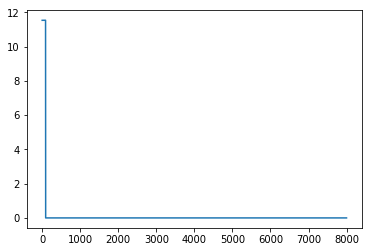

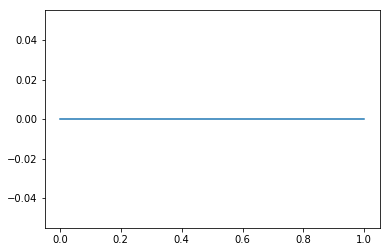

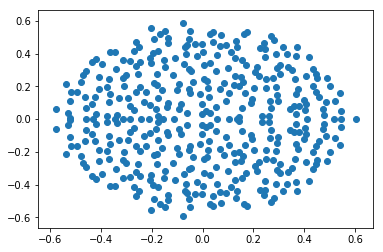

In [18]:
#plt.plot(len_h2h_grad)
#print(model.h2h.weight.detach().numpy().ravel()[np.where(model.h2h_mask.flatten())].std())
#print(g / np.sqrt(hidden_size * prob_conn))
plt.figure()
plt.plot(len_Wh2h)
# plt.plot(len_Wh2h)
# plt.plot(len_Wh2o)

plt.figure()
plt.plot(losses)

l,v = np.linalg.eig(model.h2h.weight.data)
plt.figure()
plt.scatter(np.real(l),np.imag(l))

1.0

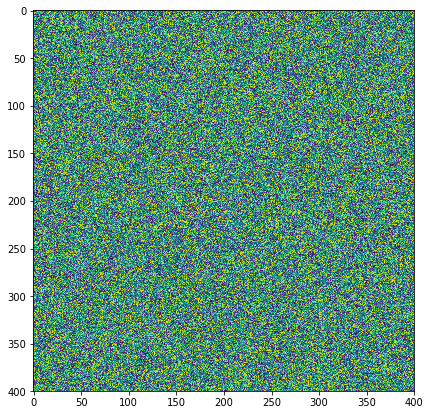

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(model.h2h.weight.detach().numpy(), interpolation='none', cmap='viridis')

(~np.isclose(h2h,0)).sum() / h2h.size
# np.savez('model_g1.5.npz',model.i2h.weight.detach().numpy(), model.h2h.weight.detach().numpy(), model.h2o.weight.detach().numpy())
#model.h2h.weight.detach().numpy().ravel()[np.where(~(model.h2h_mask != 0).flatten())].min()

In [ ]:
# ix = np.where(Wh2h[0])
# h2h_nz = Wh2h[:,ix[0],ix[1]]
#_ = plt.hist(np.diff(h2h_nz).sum(1))
# plt.figure(figsize=(10,10))
# plt.imshow(Wh2h[0], interpolation = 'none')

# Intrinsic dynamics -- Post-training

In [11]:
test_steps = 2500
test_batch_size = 8

with torch.no_grad():
    hidden = 2*torch.rand((test_batch_size, hidden_size))-1
    out, hid = model(torch.zeros(test_batch_size, test_steps, input_size), hidden)
    intrinsic_out = out.detach().numpy()
    intrinsic_hid = hid.detach().numpy()

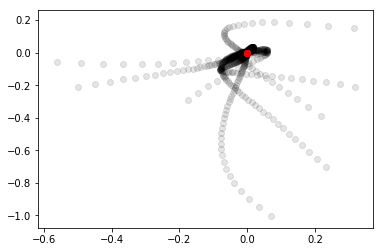

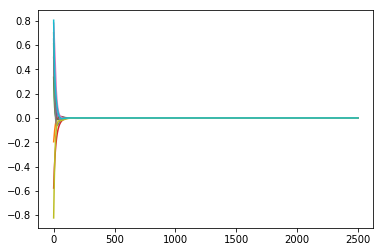

In [12]:
plt.figure()
plt.scatter(*intrinsic_out[:,:int(test_steps/20),:].T, color = 'k', alpha = 0.1)
plt.scatter(*intrinsic_out[:,-int(test_steps/20):,:].T, color = 'r', alpha = 0.1)

plt.figure()
i=np.random.randint(test_batch_size)
k=np.random.randint(0, hidden_size, 10)
_ = plt.plot(intrinsic_hid[i,:,k].T)

#     plt.xlim([-1,1])
#     plt.ylim([-1,1])
#plt.scatter(*targets[:,0,:].numpy().T, color='r')
# TODO?: convex hull of samples vs time, as a measure of convergence to single FP

# Stimulus-Evoked Dynamics


In [13]:
final_steps = 1000
test_batch_size = 8

with torch.no_grad():
    inputs, targets = get_batch(input_size, xmin, xmax, test_batch_size, n_steps, pulse_width)
    test_targ = targets[:,-1,:].numpy()
    hidden = 2*torch.rand((test_batch_size, hidden_size))-1
    #torch.zeros(test_batch_size, init_steps, input_size) <-- init_steps now included in get_batch() output
    out, hid = model(torch.cat((inputs,
                                torch.zeros(test_batch_size, final_steps, input_size)),
                              dim=1),
                     hidden)
    test_out = out.detach().numpy()
    test_hid = hid.detach().numpy()

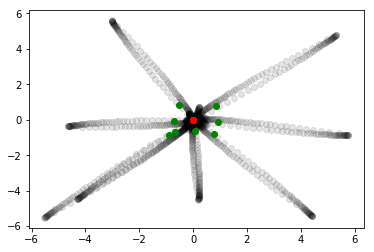

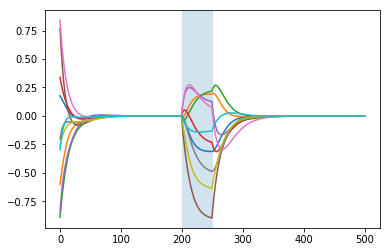

In [14]:
plt.figure()
plt.scatter(*test_out[:,:int(test_steps/5),:].T, color = 'k', alpha = 0.1)
plt.scatter(*test_out[:,-int(test_steps/5):,:].T, color = 'r', alpha = 0.1)
plt.scatter(*test_targ.T, color='g')

plt.figure()
i=np.random.randint(test_batch_size)
k=np.random.randint(0, hidden_size, 10)
_ = plt.plot(test_hid[i,:500,k].T)
_ = plt.axvspan(init_steps, init_steps+pulse_width, alpha=0.2)

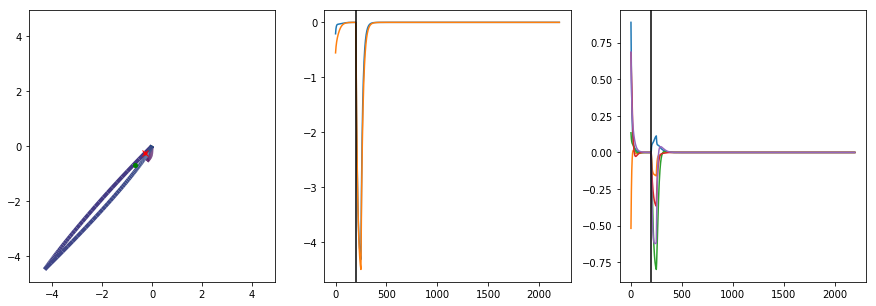

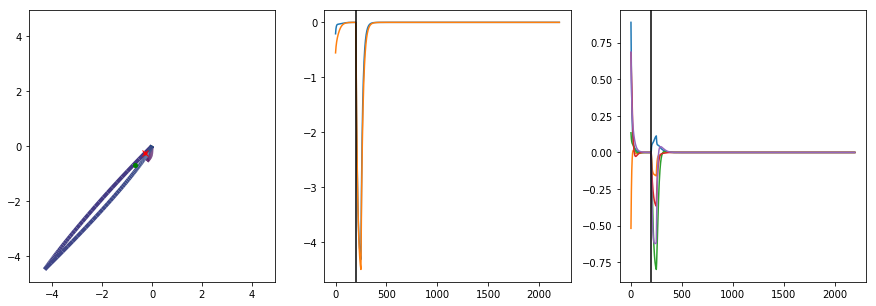

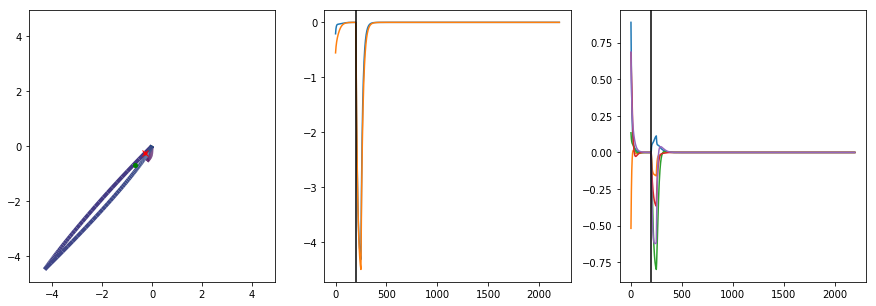

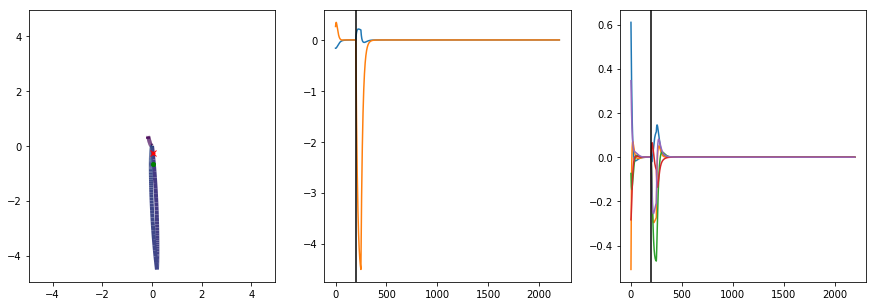

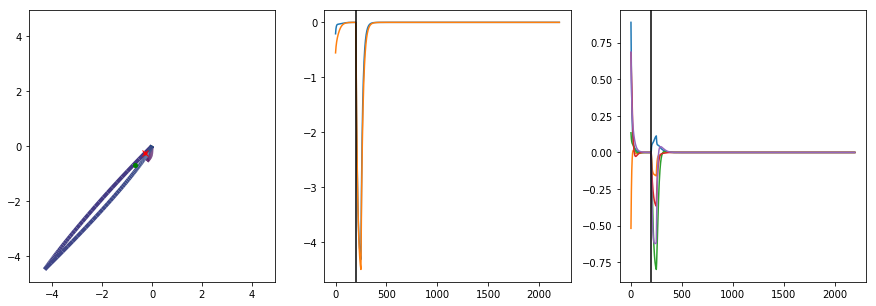

In [15]:
for i in np.random.randint(0,test_batch_size,5):
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    #x,y = test_out[i,:500,:].T
    points = test_out[i].reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0, init_steps + n_steps)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.arange(init_steps + n_steps))
    lc.set_linewidth(4)
    line = ax[0].add_collection(lc)
    ax[0].plot(*test_out[i,init_steps].T, 'rx')
    ax[0].plot(*test_out[i,init_steps].T, 'r.')
    ax[0].plot(*test_targ[i].T, 'g.', markersize=8)
    pmax = 1.1*np.abs(points).max()
    ax[0].set_xlim(-pmax, pmax)
    ax[0].set_ylim(-pmax, pmax)
    ax[1].plot(test_out[i])
    ax[1].axvline(init_steps, color='k')
    ax[2].plot(test_hid[i,:,:5])
    ax[2].axvline(init_steps, color='k')
    

In [ ]:
hid_idx = np.random.randint(0,hidden_size,20)
fig, ax = plt.subplots(10,1,sharex=True, figsize=(5,10))
for axi, i in zip(ax.ravel(), hid_idx):
    axi.plot(test_hid[0,:500,i].T)
    axi.axvline(init_steps, color='r')
    axi.axvline(init_steps + pulse_width, color='r')
#plt.figure()
#_ = plt.plot(test_hid[0,:,hid_idx].T)

In [ ]:
_ = plt.plot(test_hid[0,:,:10])

In [ ]:
cmats = []
# for i in range(n_test):
for j in range(test_batch_size):
    cmats.append(np.corrcoef(test_hid[j].T))

#cmats = np.array(cmats).reshape(5,3)



In [ ]:
# fig, ax = plt.subplots(num_pats, num_test)
print(len(cmats))

for x in cmats[::test_batch_size]:
    plt.figure(figsize =(8,8))
    plt.imshow(x, interpolation = 'none')

In [ ]:
#i=0
# for j in np.random.randint(0,batch_size,10):
#     plt.figure()
#     for t in range(init_steps):
#         plt.scatter(*test_out[i,j,t,:].T, color='k', alpha=0.1+0.9*t/(init_steps+n_steps))
#     for t in range(init_steps,init_steps+100):
#         plt.scatter(*test_out[i,j,t,:].T, color='r', alpha=0.1+0.9*t/(init_steps+n_steps))
#     for t in range(init_steps+100,init_steps+n_steps):
#         plt.scatter(*test_out[i,j,t,:].T, color='b', alpha=0.1+0.9*t/(init_steps+n_steps))    
#     plt.scatter(*test_targ[i,j,:].T, color = 'g')
#     plt.gca().set_aspect('equal')
#     #plt.xlim([-2,2])
#     #plt.ylim([-2,2])

# for t in range():
#     plt.scatter(*test_out[0,0,t,:].T, color='r', alpha=0.1+0.9*t/200.)

#plt.scatter(*test_out[i,:,-int(test_steps/4):,:].T)
#plt.scatter(torch.cat((torch.zeros(batch_size, init_steps, input_size), inputs), dim=1)[:,100,:]

In [ ]:
# plt.figure()
# #for j in range(n_test):
# #     plt.plot(test_out[j,i,:100,0],
# #             test_out[j,i,:100,1])
# #     plt.plot(test_out[j,i,-100:,0],
# #             test_out[j,i,-100:,1])
#     #plt.scatter(*test_out[j,i,:int(test_steps/2),:].T)
#     #plt.scatter(*test_out[j,i,int(test_steps/2):,:].T)
#     plt.scatter(*test_out[j,i,:100,:].T)
# #    plt.xlim([-1,1])
# #    plt.ylim([-1,1])

# #plt.scatter(*targets[:,0,:].numpy().T, facecolor='r', edgecolor='k')
# # plt.scatter(*targets[:,0,:].numpy().T.mean(1), color='b')

In [ ]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [ ]:
from scipy import sparse
def testdummy(ni,nh,no,pc):
    #i2h = np.random.randn(ni,nh)
    #print(i2h.shape)
    #h2h = (1.5 / (np.sqrt(pc*nh))) * np.random.randn(nh,nh)
    mask = np.random.uniform(size=(nh,nh)) < pc
    mask *= ~np.eye(mask.shape[0]).astype(np.bool)
    row, col = np.where(mask)
    values = (1.5 / (np.sqrt(pc*nh))) * np.random.randn(len(row))
    h2h = sparse.csr_matrix((values, (row,col)), shape=mask.shape) #.todense()
    #h2h[np.where(~mask)[0],:][:,np.where(~mask)[1]] = 0.
    h2o = (1./np.sqrt(nh))*np.random.randn(no, nh)
    hidden = 2*np.random.uniform(size=(nh,1)) - 1
    dt = 0.1
    tau = 1
    hiddens = []
    outputs = []
    for i in range(1000):
        recur = h2h.dot(np.tanh(hidden))
        hidden = (1-dt)*hidden + dt*recur
        output = h2o.dot(hidden)
        hiddens.append(hidden)
        outputs.append(output)

    return np.squeeze(np.array(hiddens)), np.squeeze(np.array(outputs))

h,o = testdummy(input_size, hidden_size, input_size, 0.25)

# # plt.plot()
k=np.random.randint(0, hidden_size, 10)
plt.plot(h[:,k])
plt.figure()
plt.scatter(*o.T)

In [ ]:
# idx = np.random.choice()
def testdummy2(i2h,h2h,h2o,hidden=None):
    dt = 0.1
    tau = 1
    hiddens = []
    outputs = []
    if hidden is None:
        hidden = 2*np.random.uniform(size=(h2h.shape[0],1)) - 1

    for i in range(1000):
        recur = h2h.dot(np.tanh(hidden))
        hidden = (1-dt)*hidden + dt*recur
        output = h2o.dot(hidden)
        hiddens.append(hidden)
        outputs.append(output)

    return np.squeeze(np.array(hiddens)), np.squeeze(np.array(outputs))


test_hidden = 2*torch.rand((1, hidden_size))-1
h,o  = testdummy2(i2h, h2h, h2o, hidden=test_hidden.detach().numpy().T)
k=np.random.randint(0, hidden_size, 10)
plt.plot(h[:,k])
plt.figure()
plt.scatter(*o.T)